# Imports

In [1]:
config = {
    'dhdt': {
        'depth': 3,
        'learning_rate': 0.1,#1e-3,
        
        'initializer': 'GlorotUniform', #GlorotUniform
        'initializer_index': 'GlorotUniform', #GlorotUniform
        
        
        'loss': 'mse',#'mae',
        'optimizer': 'adam',        
        
        'beta_1': 10,
        'beta_2': 10,
        
        'sparse_activation_1': 'entmax', #softmax, entmax, sparsemax 
        'sparse_activation_2': 'entmax', #sigmoid, entmax, sparsemax 
        
        'activation': 'tanh', #sigmoid
        'squeeze_factor': 1,
        
        'batch_size': 512,
        'epochs': 1_000,
        'early_stopping_epochs': 50,
    },
    
    
    
    'make_classification': {
        'number_of_variables': 10,
        'n_samples': 10_000,
        'num_eval': 10,
        
        'noise': 0.1,
    },

    'computation': {
        'random_seed': 42,
        'trials': 3,
        'n_jobs': 60,
        'verbosity': 0,
        
        'search_iterations': 60,
    },
}



In [2]:
import numpy as np
np.set_printoptions(suppress=True)

import sklearn
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, ParameterGrid, ParameterSampler, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, f1_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, LabelEncoder, OrdinalEncoder

from livelossplot import PlotLosses

import os
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from IPython.display import Image
from IPython.display import display, clear_output

import pandas as pd

os.environ['CUDA_VISIBLE_DEVICES'] = ''
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = '' #'true'

#os.environ['TF_XLA_FLAGS'] = "--tf_xla_auto_jit=2 --tf_xla_cpu_global_jit" 


import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
os.environ["PYTHONWARNINGS"] = "ignore"
import logging

import tensorflow as tf
import tensorflow_addons as tfa

tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(3)

np.seterr(all="ignore")

from keras import backend as K
from keras.utils.generic_utils import get_custom_objects


import seaborn as sns
sns.set_style("darkgrid")

import time
import random

from utilities.utilities import *
from utilities.DHDT import *

from joblib import Parallel, delayed

from itertools import product
from collections.abc import Iterable

from copy import deepcopy

tf.random.set_seed(config['computation']['random_seed'])
np.random.seed(config['computation']['random_seed'])
random.seed(config['computation']['random_seed'])

# Evaluation

## make_classification

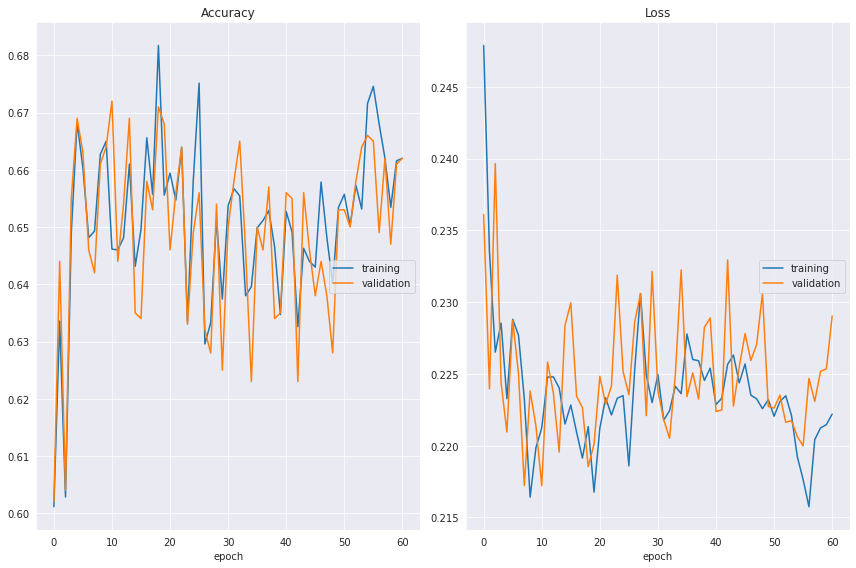

Accuracy
	training         	 (min:    0.601, max:    0.682, cur:    0.662)
	validation       	 (min:    0.602, max:    0.672, cur:    0.662)
Loss
	training         	 (min:    0.216, max:    0.248, cur:    0.222)
	validation       	 (min:    0.217, max:    0.240, cur:    0.229)
Test accuracy Sklearn (0) 0.7015
Test accuracy DHDT (0) 0.66
________________________________________________________________________________________________________
Test f1 Sklearn (0) 0.7554281032363785
Test f1 DHDT (0) 0.7048611111111112
________________________________________________________________________________________________________


In [3]:
if True:
    tf.random.set_seed(config['computation']['random_seed'])
    np.random.seed(config['computation']['random_seed'])
    random.seed(config['computation']['random_seed'])  
    
    metrics = ['accuracy', 'f1']
    
    config_test = deepcopy(config)
    #config_test['make_classification']['n_samples'] = 10_000
    config_test['dhdt']['epochs'] = 500
    #config_test['dhdt']['initializer_index'] = 'he_normal'#'ones', #GlorotUniform
    #config_test['dhdt']['activation'] = 'sigmoid'

    dataset_dict = {}
    model_dict = {}

    scores_dict = {'sklearn': {},
                   'DHDT': {}}
    
    dataset_dict = get_preprocessed_dataset('make_classification',
                                            random_seed=config_test['computation']['random_seed'],
                                            config=config_test['make_classification'],
                                            verbosity=2)

    model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_test['dhdt']['depth'], 
                                                   random_state=config_test['computation']['random_seed'])

    model_dict['sklearn'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'])



    model_dict['DHDT'] = DHDT(dataset_dict['X_train'].shape[1],

                                depth = config_test['dhdt']['depth'],

                                learning_rate = config_test['dhdt']['learning_rate'],
                                optimizer = config_test['dhdt']['optimizer'],
                              
                                initializer = config_test['dhdt']['initializer'],
                                initializer_index = config_test['dhdt']['initializer_index'],
                              
                                beta_1 = config_test['dhdt']['beta_1'],
                                beta_2 = config_test['dhdt']['beta_2'],

                                activation = config_test['dhdt']['activation'],
                                squeeze_factor = config_test['dhdt']['squeeze_factor'],

                                loss = config_test['dhdt']['loss'],#'mae',

                                random_seed = config_test['computation']['random_seed'],
                                verbosity = 1)#5        


    scores_dict['history'] = model_dict['DHDT'].fit(dataset_dict['X_train'], 
                                                  dataset_dict['y_train'], 
                                                  batch_size=config_test['dhdt']['batch_size'], 
                                                  epochs=config_test['dhdt']['epochs'], 
                                                  early_stopping_epochs=config_test['dhdt']['early_stopping_epochs'], 
                                                  valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


    dataset_dict['y_test_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_valid'])

    dataset_dict['y_test_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_valid'])     
    
    for metric in metrics:
        
        if metric in ['accuracy', 'f1']:
            y_test_dhdt = np.round(dataset_dict['y_test_dhdt'])
            y_valid_dhdt = np.round(dataset_dict['y_valid_dhdt'])
            y_test_sklearn = np.round(dataset_dict['y_test_sklearn'])
            y_valid_sklearn = np.round(dataset_dict['y_valid_sklearn'])         
        else:
            y_test_dhdt = dataset_dict['y_test_dhdt']
            y_valid_dhdt = dataset_dict['y_valid_dhdt']
            y_test_sklearn = dataset_dict['y_test_sklearn']
            y_valid_sklearn =    dataset_dict['y_valid_sklearn']                
        
        scores_dict['sklearn'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_sklearn)
        scores_dict['DHDT'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_dhdt)

        scores_dict['sklearn'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_sklearn)   
        scores_dict['DHDT'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_dhdt)

        print('Test ' + metric + ' Sklearn (' + str(0) + ')', scores_dict['sklearn'][metric + '_test'])
        print('Test ' + metric + ' DHDT (' + str(0) + ')', scores_dict['DHDT'][metric + '_test'])   
        print('________________________________________________________________________________________________________')   


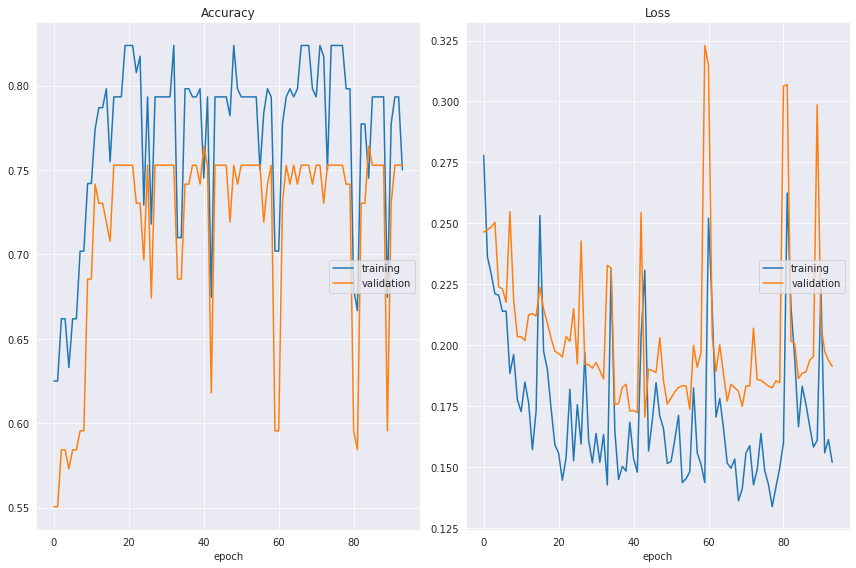

Accuracy
	training         	 (min:    0.625, max:    0.824, cur:    0.750)
	validation       	 (min:    0.551, max:    0.764, cur:    0.753)
Loss
	training         	 (min:    0.134, max:    0.278, cur:    0.152)
	validation       	 (min:    0.170, max:    0.323, cur:    0.191)
Test accuracy Sklearn (0) 0.797752808988764
Test accuracy DHDT (0) 0.7808988764044944
________________________________________________________________________________________________________
Test f1 Sklearn (0) 0.7352941176470589
Test f1 DHDT (0) 0.7234042553191489
________________________________________________________________________________________________________


In [4]:
if True:
    tf.random.set_seed(config['computation']['random_seed'])
    np.random.seed(config['computation']['random_seed'])
    random.seed(config['computation']['random_seed'])  
    
    metrics = ['accuracy', 'f1']
    
    config_test = deepcopy(config)
    #config_test['make_classification']['n_samples'] = 10_000
    config_test['dhdt']['epochs'] = 500
    #config_test['dhdt']['initializer_index'] = 'he_normal'#'ones', #GlorotUniform
    #config_test['dhdt']['activation'] = 'sigmoid'

    dataset_dict = {}
    model_dict = {}

    scores_dict = {'sklearn': {},
                   'DHDT': {}}
    
    dataset_dict = get_preprocessed_dataset('Titanic',
                                            random_seed=config_test['computation']['random_seed'],
                                            config=config_test['make_classification'],
                                            verbosity=2)

    model_dict['sklearn'] = DecisionTreeClassifier(max_depth=config_test['dhdt']['depth'], 
                                                   random_state=config_test['computation']['random_seed'])

    model_dict['sklearn'].fit(dataset_dict['X_train'], 
                              dataset_dict['y_train'])



    model_dict['DHDT'] = DHDT(dataset_dict['X_train'].shape[1],

                                depth = config_test['dhdt']['depth'],

                                learning_rate = config_test['dhdt']['learning_rate'],
                                optimizer = config_test['dhdt']['optimizer'],
                              
                                initializer = config_test['dhdt']['initializer'],
                                initializer_index = config_test['dhdt']['initializer_index'],
                              
                                beta_1 = config_test['dhdt']['beta_1'],
                                beta_2 = config_test['dhdt']['beta_2'],

                                activation = config_test['dhdt']['activation'],
                                squeeze_factor = config_test['dhdt']['squeeze_factor'],

                                loss = config_test['dhdt']['loss'],#'mae',

                                random_seed = config_test['computation']['random_seed'],
                                verbosity = 1)#5        


    scores_dict['history'] = model_dict['DHDT'].fit(dataset_dict['X_train'], 
                                                  dataset_dict['y_train'], 
                                                  batch_size=config_test['dhdt']['batch_size'], 
                                                  epochs=config_test['dhdt']['epochs'], 
                                                  early_stopping_epochs=config_test['dhdt']['early_stopping_epochs'], 
                                                  valid_data=(dataset_dict['X_valid'], dataset_dict['y_valid']))


    dataset_dict['y_test_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_dhdt'] = model_dict['DHDT'].predict(dataset_dict['X_valid'])

    dataset_dict['y_test_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_test'])
    dataset_dict['y_valid_sklearn'] = model_dict['sklearn'].predict(dataset_dict['X_valid'])     
    
    for metric in metrics:
        
        if metric in ['accuracy', 'f1']:
            y_test_dhdt = np.round(dataset_dict['y_test_dhdt'])
            y_valid_dhdt = np.round(dataset_dict['y_valid_dhdt'])
            y_test_sklearn = np.round(dataset_dict['y_test_sklearn'])
            y_valid_sklearn = np.round(dataset_dict['y_valid_sklearn'])         
        else:
            y_test_dhdt = dataset_dict['y_test_dhdt']
            y_valid_dhdt = dataset_dict['y_valid_dhdt']
            y_test_sklearn = dataset_dict['y_test_sklearn']
            y_valid_sklearn =    dataset_dict['y_valid_sklearn']                
        
        scores_dict['sklearn'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_sklearn)
        scores_dict['DHDT'][metric + '_test'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_test'], y_test_dhdt)

        scores_dict['sklearn'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_sklearn)   
        scores_dict['DHDT'][metric + '_valid'] = sklearn.metrics.get_scorer(metric)._score_func(dataset_dict['y_valid'], y_valid_dhdt)

        print('Test ' + metric + ' Sklearn (' + str(0) + ')', scores_dict['sklearn'][metric + '_test'])
        print('Test ' + metric + ' DHDT (' + str(0) + ')', scores_dict['DHDT'][metric + '_test'])   
        print('________________________________________________________________________________________________________')   


In [5]:
dataset_dict['X_train'].head()

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare
367,1.0,-1.0,-1.0,-1.0,1.0,-0.264159,-1.00,-1.0,-0.971779
569,-1.0,-1.0,1.0,1.0,1.0,-0.206333,-1.00,-1.0,-0.969339
612,-1.0,1.0,-1.0,-1.0,1.0,-0.264159,-0.75,-1.0,-0.939492
115,-1.0,-1.0,1.0,1.0,1.0,-0.482785,-1.00,-1.0,-0.969063
157,-1.0,-1.0,1.0,1.0,1.0,-0.256597,-1.00,-1.0,-0.968575


In [6]:
if True:   
    normalizer_list = dataset_dict['normalizer_list']
    if normalizer_list is not None: 
        transpose_normalized = []
        for i, column_name in enumerate(dataset_dict['X_train']):
            column = deepcopy(dataset_dict['X_train'][column_name])
            column_new = column
            if len(column_new[column_new != 0]) != 0:
                column_new[column_new != 0] = normalizer_list[i].inverse_transform([column[column != 0]])
                #column_new = normalizer_list[i].inverse_transform(column.reshape(-1, 1)).ravel()
            transpose_normalized.append(column_new)
        data = pd.DataFrame(np.array(transpose_normalized).transpose(), columns=dataset_dict['X_train'].columns).round(1)
        display(data.head())

,cat__x0_C,cat__x0_Q,cat__x0_S,Sex,Pclass,Age,SibSp,Parch,Fare
0,1.0,0.0,0.0,0.0,3.0,29.7,0.0,0.0,7.2
1,0.0,0.0,1.0,1.0,3.0,32.0,0.0,0.0,7.9
2,0.0,1.0,0.0,0.0,3.0,29.7,1.0,0.0,15.5
3,0.0,0.0,1.0,1.0,3.0,21.0,0.0,0.0,7.9
4,0.0,0.0,1.0,1.0,3.0,30.0,0.0,0.0,8.0


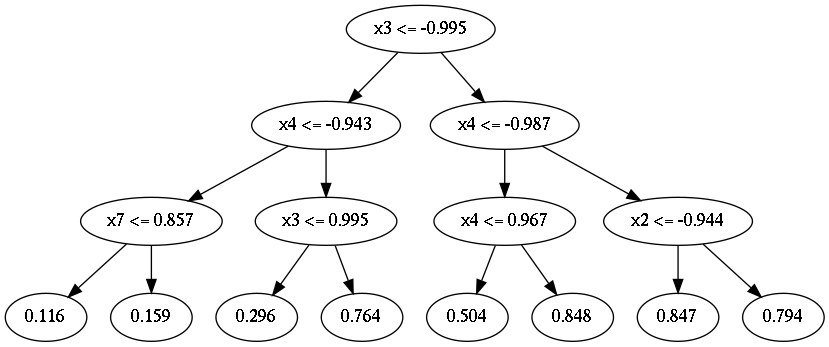

<Figure size 1080x576 with 0 Axes>

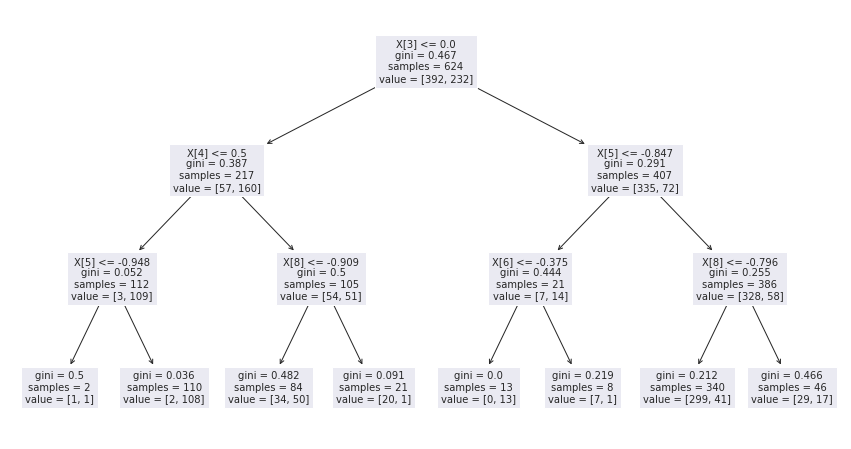

In [7]:
if True:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot()
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

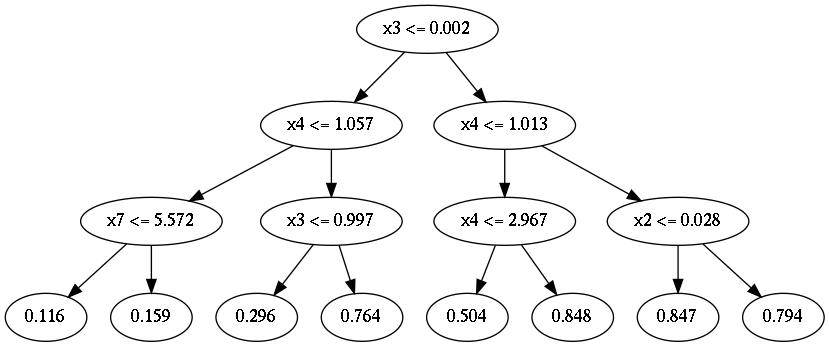

<Figure size 1080x576 with 0 Axes>

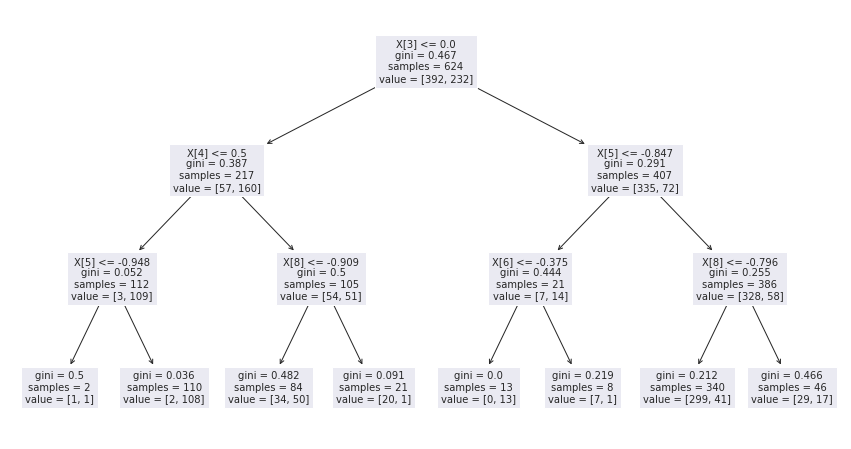

In [8]:
if True:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot(normalizer_list=dataset_dict['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [9]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot()
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [10]:
if False:    
    plt.figure(figsize=(15,8))
    image = model_dict['DHDT'].plot(normalizer_list=dataset_dict['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict['sklearn'], fontsize=10) 
    plt.show()

In [11]:
if False:
    parallel_eval_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_synthetic = parallel_eval_synthetic(delayed(evaluate_synthetic_parallel)(index = index,
                                                                                                random_seed_data = config['computation']['random_seed']+index,
                                                                                                random_seed_model = config['computation']['random_seed'],#+random_seed_model,
                                                                                                config = config,
                                                                                                verbosity = -1) for index in range(config['make_classification']['num_eval']))

    for i, synthetic_result in enumerate(evaluation_results_synthetic):
        if i == 0:
            model_dict_synthetic = synthetic_result[0]
            scores_dict_synthetic = synthetic_result[1]
            dataset_dict_synthetic = synthetic_result[2]
        else: 
            model_dict_synthetic = mergeDict(model_dict_synthetic, synthetic_result[0])
            scores_dict_synthetic = mergeDict(scores_dict_synthetic, synthetic_result[1])
            dataset_dict_synthetic = mergeDict(dataset_dict_synthetic, synthetic_result[2])        
    
    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = [i for i in range(config['make_classification']['num_eval'])]
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_synthetic[i]['DHDT'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_sklearn = [scores_dict_synthetic[i]['sklearn'][metric + metric_identifer] for i in range(config['make_classification']['num_eval'])]

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])

    scores_dataframe_synthetic = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)    
        
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:].index]
    mean_result_dataframe_synthetic = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_synthetic.mean()[:scores_dataframe_synthetic.shape[1]//2], scores_dataframe_synthetic.mean()[scores_dataframe_synthetic.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)

        
    display(scores_dataframe_synthetic.head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[0::3]].iloc[:,[0,2,1,3]].head(5))
    display(scores_dataframe_synthetic[scores_dataframe_synthetic.columns[1::3]].iloc[:,[0,2,1,3]].head(5))
    display(mean_result_dataframe_synthetic)
    

In [12]:
if False:
    plot_index = 0
    
    plt.figure(figsize=(15,8))
    image = model_dict_synthetic[1]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_synthetic[1]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_synthetic[1]['sklearn'][plot_index], fontsize=10) 
    plt.show()

## Real-World Eval

In [13]:
if False:

    identifier_list = [
                        'Adult',#: 32,
                        'Bank Marketing',#: 32,
                        'Loan Credit',#: 32,

                        'Credit Card',#: 23, 
                        'Car',#: 21,


                        'Absenteeism',#: 15,
                        'Loan House',#: 15,
                        'Cervical Cancer',#: 15,

                        'Heart Disease',#: 13,           

                        'Titanic',#: 10,
                        'Medical Insurance',#: 10,
                        'Wisconsin Breast Cancer Original',#: 10,
                        'Wisconsin Diagnostic Breast Cancer',#: 10,
                        'Wisconsin Prognostic Breast Cancer',#: 10,
                        'Abalone',#: 10,

                        'Habermans Survival',#: 3, 
                      ]
    
    parallel_eval_real_world = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_real_world = parallel_eval_real_world(delayed(evaluate_real_world_parallel)(identifier_list=identifier_list, 
                                                                                                   random_seed_model=config['computation']['random_seed']+i,
                                                                                                   config = config,
                                                                                                   verbosity = -1) for i in range(config['computation']['trials']))


    for i, real_world_result in enumerate(evaluation_results_real_world):
        if i == 0:
            model_dict_real_world = real_world_result[0]
            scores_dict_real_world = real_world_result[1]
            dataset_dict_real_world = real_world_result[2]
        else: 
            model_dict_real_world = mergeDict(model_dict_real_world, real_world_result[0])
            scores_dict_real_world = mergeDict(scores_dict_real_world, real_world_result[1])
            dataset_dict_real_world = mergeDict(dataset_dict_real_world, real_world_result[2])    

    metric_identifer = '_test'
    metrics = ['accuracy', 'f1']
    index = identifier_list
    columns = flatten_list([[[approach + ' ' + metric + '_mean', approach + ' ' + metric + '_max', approach + ' ' + metric + '_std'] for metric in metrics] for approach in ['DHDT', 'sklearn']])


    results_DHDT = None
    results_sklearn = None
    for metric in metrics:
        scores_DHDT = [scores_dict_real_world[identifier]['DHDT'][metric + metric_identifer] for identifier in identifier_list]

        scores_sklearn = [scores_dict_real_world[identifier]['sklearn'][metric + metric_identifer] for identifier in identifier_list]    

        scores_DHDT_mean = np.mean(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_mean = np.mean(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_max = np.max(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else scores_DHDT
        scores_sklearn_max = np.max(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else scores_sklearn

        scores_DHDT_std = np.std(scores_DHDT, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])
        scores_sklearn_std = np.std(scores_sklearn, axis=1) if config['computation']['trials'] > 1 else np.array([0.0] * config['computation']['trials'])

        results_DHDT_by_metric = np.vstack([scores_DHDT_mean, scores_DHDT_max, scores_DHDT_std])
        results_sklearn_by_metric = np.vstack([scores_sklearn_mean, scores_sklearn_max, scores_sklearn_std])

        if results_DHDT is None and results_sklearn is None:
            results_DHDT = results_DHDT_by_metric
            results_sklearn = results_sklearn_by_metric
        else:
            results_DHDT = np.vstack([results_DHDT, results_DHDT_by_metric])
            results_sklearn = np.vstack([results_sklearn, results_sklearn_by_metric])
            
    scores_dataframe_real_world = pd.DataFrame(data=np.vstack([results_DHDT, results_sklearn]).T, index = index, columns = columns)
            
    index = [index_name.split(' ')[1] for index_name in scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:].index]
    mean_result_dataframe_real_world = np.round(pd.DataFrame(data=np.vstack([scores_dataframe_real_world.mean()[:scores_dataframe_real_world.shape[1]//2], scores_dataframe_real_world.mean()[scores_dataframe_real_world.shape[1]//2:]]).T, index=index, columns=['DHDT', 'sklearn']), 3)
                
    display(scores_dataframe_real_world)
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[0::3]].iloc[:,[0,2,1,3]])    
    display(scores_dataframe_real_world[scores_dataframe_real_world.columns[1::3]].iloc[:,[0,2,1,3]])    

    display(mean_result_dataframe_real_world)
    


In [14]:
if False:
    plot_index = 0
    
    identifier = identifier_list[0]#"Absenteeism"
    plt.figure(figsize=(15,8))
    image = model_dict_real_world[identifier]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_real_world[identifier]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_real_world[identifier]['sklearn'][plot_index], fontsize=10) 
    plt.show()

# Hyperparameter Optimization

In [15]:
parameter_dict = {
        'depth': [config['dhdt']['depth']],
        'learning_rate': [0.001, 0.025, 0.005, 0.01, 0.025, 0.05, 0.1, 0.25], #[0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001],
        
        'loss': ['binary_crossentropy', 'mse'], #['binary_crossentropy', 'rmse'], #'mae',
        'optimizer': ['adam', 'rmsprop'], #['adam'], #['adam', 'sgd', 'rmsprop'],        
        
        'initializer': ['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform', 'Zeros', 'Ones'],#'GlorotUniform', 'GlorotNormal',  #['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform'], #RandomNormal, RandomUniform
        'initializer_index': ['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform', 'Zeros', 'Ones'],#['GlorotUniform', 'GlorotNormal', 'HeUniform', 'HeNormal', 'LecunUniform', 'LecunNormal', 'RandomNormal', 'RandomUniform', 'Zeros', 'Ones'], #RandomNormal, RandomUniform

        #'beta_1': [1, 5, 10, 20, 50], #[10, 50, 100],
        #'beta_2': [1, 5, 10, 20, 50], #[10, 50, 100],
    
        #'sparse_activation_1': ['softmax', 'entmax', 'sparsemax'], #softmax, entmax, sparsemax 
        #'sparse_activation_2': ['sigmoid', 'entmax', 'sparsemax'], #sigmoid, entmax, sparsemax     
        
        'activation': ['tanh'], #'sigmoid'
        'squeeze_factor': [0.2, 0.5, 1, 2, 5], #[0.2, 0.5, 1, 2, 5],    
}

#parameter_grid = ParameterGrid(parameter_dict)
parameter_grid = ParameterSampler(n_iter = config['computation']['search_iterations'],
                                  param_distributions = parameter_dict,
                                  random_state = config['computation']['random_seed'])

In [16]:
if False:   
    print('Number of Trials: ' + str(len(parameter_grid)))
    
    parallel_hpo_synthetic = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
    evaluation_results_hpo_synthetic = parallel_hpo_synthetic(delayed(evaluate_parameter_setting_synthetic)(parameter_setting, config, metrics= ['accuracy', 'f1']) for parameter_setting in parameter_grid)

    comparator_metric = 'f1'

    dhdt_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    dhdt_mean_list = sorted(dhdt_mean_list_unsorted, reverse=True)

    dhdt_max_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
    dhdt_max_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, dhdt_max_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, dhdt_max_mean_list), reverse=True)]

    sklearn_mean_list_unsorted = [np.mean(evaluation_results_hpo_synthetic[i][0]['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
    sklearn_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, sklearn_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, sklearn_mean_list), reverse=True)]

    parameter_setting_list_unsorted = [evaluation_results_hpo_synthetic[i][1] for i in range(len(parameter_grid))]
    parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]
    #[x for _, x in sorted(zip(dhdt_mean_list, parameter_setting_list), reverse=True)]

    hpo_results_synthetic = []
    for i, (dhdt_mean, dhdt_max_mean, sklearn_mean, parameter_setting) in enumerate(zip(dhdt_mean_list, dhdt_max_mean_list, sklearn_mean_list, parameter_setting_list)):
        result_dict = {
                             'DHDT mean (mean)': dhdt_mean,
                             'DHDT max (mean)': dhdt_max_mean,
                             'sklearn mean': sklearn_mean,
                             'parameters': parameter_setting
                            }

        hpo_results_synthetic.append(result_dict)

    display(hpo_results_synthetic[:5])

In [17]:
def evaluate_parameter_setting_gen(parameter_setting, dataset_dict):    
    base_model_gen = GeneticTree()
    base_model_gen.set_params(**parameter_setting)

    base_model_gen.fit(dataset_dict['X_train'].values, dataset_dict['y_train'].values)

    base_model_gen_pred = base_model_gen.predict(dataset_dict['X_valid'].values)

    f1_score_base_model_gen = f1_score(dataset_dict['y_valid'].values, np.round(base_model_gen_pred), average='weighted')

    return (f1_score_base_model_gen, parameter_setting)

In [18]:
if True:
    identifier_list = [
                        'Adult',#: 32, 100 random 7.4min
                        'Bank Marketing',#: 32, 100 random 8.0min
                        'Loan Credit',#: 32, 100 random 11.0min

                        'Credit Card',#: 23, 100 random 9.7min
                        'Car',#: 21, 100 random 4.1min


                        'Absenteeism',#: 15, 100 random 2.9min
                        'Loan House',#: 15,  100 random 2.6min
                        'Cervical Cancer',#: 15, 100 random 1.4min

                        'Heart Disease',#: 13, 100 random 1.7min       

                        'Titanic',#: 10, 100 random 2.9min
                        'Medical Insurance',#: 10, 100 random 3.0min
                        'Wisconsin Breast Cancer Original',#: 10, 100 random 2.5min
                        'Wisconsin Diagnostic Breast Cancer',#: 10, 100 random 1.4min
                        'Wisconsin Prognostic Breast Cancer',#: 10, 100 random 1.4min
                        'Abalone',#: 10, 100 random 2.6min

                        'Habermans Survival',#: 3, 100 random 1.4min
                      ]

    hpo_results_real_world_valid = {}
    hpo_results_real_world_unsorted_valid = {}
    hpo_results_real_world_test = {}
    hpo_results_real_world_unsorted_test = {}
        
    print('___________________________________________________________________________')
    
    for identifier in identifier_list:
        print(identifier)
        
        dataset_dict = get_preprocessed_dataset(identifier,
                                                random_seed=config['computation']['random_seed'],
                                                config=config['make_classification'],
                                                verbosity=0)  

        base_model = DecisionTreeClassifier()

        parameter_dict_sklearn = {
                'max_depth': [config['dhdt']['depth']],
                'random_state': [config['computation']['random_seed']],
                'criterion': ['gini', 'entropy', 'log_loss'], 
                'min_samples_split': [0, 2, 5, 10, 50], 
                'min_samples_leaf': [0, 2, 5, 10, 50], 
                'min_weight_fraction_leaf': [0.0, 0.1, 0.5, 0.8], 
                'max_features': ['auto', 'sqrt', 'log2', None], 
                'max_leaf_nodes': [0,1,2,5,10,None], 
                'min_impurity_decrease': [0.0, 0.1, 0.5, 0.8], 
                'ccp_alpha': [0.0, 0.1, 0.5, 0.8],    
        }


        clf_sklearn = RandomizedSearchCV(n_iter=config['computation']['search_iterations'],
                                         estimator = base_model, 
                                         param_distributions = parameter_dict_sklearn,
                                         scoring=make_scorer(f1_score, average='weighted'),
                                         cv=2,
                                         verbose=1)
        
        
        clf_sklearn.fit(dataset_dict['X_train'], dataset_dict['y_train'])

        sklearn_params = clf_sklearn.best_params_
        
        display(sklearn_params)           
        
        base_model = DecisionTreeClassifier()
        base_model.set_params(**sklearn_params)

        start_sklearn = timeit.default_timer()

        base_model.fit(dataset_dict['X_train'], 
                       dataset_dict['y_train'])    


        end_sklearn = timeit.default_timer()  
        runtime_sklearn = end_sklearn - start_sklearn        
        
        
                
        parameter_dict_gen = {
                'n_thresholds': [5, 10, 20],
            
                'n_trees': [50, 100, 250, 500],
                'max_iter': [10, 50, 100, 250, 500],
                'cross_prob': [0.2, 0.4, 0.6, 0.8],
                'mutation_prob': [0.2, 0.4, 0.6, 0.8],
            
                'early_stopping': [True],
            
                'max_depth': [config['dhdt']['depth']],
                'random_state': [config['computation']['random_seed']],
                'n_jobs': [1],    
        }


        
        #parameter_grid_gen = ParameterGrid(parameter_dict_gen)
        parameter_grid_gen = ParameterSampler(n_iter = config['computation']['search_iterations'],
                                           param_distributions = parameter_dict_gen,
                                           random_state = config['computation']['random_seed'])
        
        print('Number of Trials GenTree: ' + str(len(parameter_grid_gen)))
        
        parallel_hpo_gen = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
        grid_search_results = parallel_hpo_gen(delayed(evaluate_parameter_setting_gen)(parameter_setting, dataset_dict) for parameter_setting in parameter_grid_gen)           

        grid_search_results_sorted = sorted(grid_search_results, key=lambda tup: tup[0], reverse=True) 
            
        gen_params = grid_search_results_sorted[0][1]
        
        
        base_model_gen = GeneticTree()
        base_model_gen.set_params(**gen_params)
        
        start_gen = timeit.default_timer()
        base_model_gen.fit(dataset_dict['X_train'].values, dataset_dict['y_train'].values)       
        end_gen = timeit.default_timer()  
        runtime_gen = end_gen - start_gen 
        
        display(grid_search_results_sorted[0])

        display(gen_params)   
        
        print('Number of Trials DHDT: ' + str(len(parameter_grid)))
    
        parallel_hpo_real = Parallel(n_jobs=config['computation']['n_jobs'], verbose=3, backend='loky') #loky #sequential multiprocessing
        evaluation_results_hpo_real = parallel_hpo_real(delayed(evaluate_parameter_setting_real_world)(parameter_setting, 
                                                                                                       identifier, 
                                                                                                       config, 
                                                                                                       sklearn_params = (runtime_sklearn, clf_sklearn.best_estimator_),#sklearn_params,
                                                                                                       gen_params = (runtime_gen, base_model_gen),#gen_params,
                                                                                                       metrics = ['accuracy', 'f1']) for parameter_setting in parameter_grid)

        comparator_metric = 'f1'        
        
        dhdt_mean_list_unsorted_valid = [np.mean(evaluation_results_hpo_real[i][0]['valid']['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        dhdt_mean_list_valid = sorted(dhdt_mean_list_unsorted_valid, reverse=True)
        dhdt_mean_list_unsorted_test = [np.mean(evaluation_results_hpo_real[i][0]['test']['DHDT ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        dhdt_mean_list_test = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, dhdt_mean_list_unsorted_test), key=lambda pair: pair[0], reverse=True)]
        
        
        dhdt_max_mean_list_unsorted_valid = [np.mean(evaluation_results_hpo_real[i][0]['valid']['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
        dhdt_max_mean_list_valid = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, dhdt_max_mean_list_unsorted_valid), key=lambda pair: pair[0], reverse=True)]
        dhdt_max_mean_list_unsorted_test = [np.mean(evaluation_results_hpo_real[i][0]['test']['DHDT ' + comparator_metric + '_max']) for i in range(len(parameter_grid))]
        dhdt_max_mean_list_test = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, dhdt_max_mean_list_unsorted_test), key=lambda pair: pair[0], reverse=True)]
        
        sklearn_mean_list_unsorted_valid = [np.mean(evaluation_results_hpo_real[i][0]['valid']['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        sklearn_mean_list_valid = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, sklearn_mean_list_unsorted_valid), key=lambda pair: pair[0], reverse=True)]
        sklearn_mean_list_unsorted_test = [np.mean(evaluation_results_hpo_real[i][0]['test']['sklearn ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        sklearn_mean_list_test = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, sklearn_mean_list_unsorted_test), key=lambda pair: pair[0], reverse=True)]
       
        xgb_mean_list_unsorted_valid = [np.mean(evaluation_results_hpo_real[i][0]['valid']['XGB ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        xgb_mean_list_valid = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, xgb_mean_list_unsorted_valid), key=lambda pair: pair[0], reverse=True)]
        xgb_mean_list_unsorted_test = [np.mean(evaluation_results_hpo_real[i][0]['test']['XGB ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        xgb_mean_list_test = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, xgb_mean_list_unsorted_test), key=lambda pair: pair[0], reverse=True)]    
        
        gentree_mean_list_unsorted_valid = [np.mean(evaluation_results_hpo_real[i][0]['valid']['GeneticTree ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        gentree_mean_list_valid = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, gentree_mean_list_unsorted_valid), key=lambda pair: pair[0], reverse=True)]
        gentree_mean_list_unsorted_test = [np.mean(evaluation_results_hpo_real[i][0]['test']['GeneticTree ' + comparator_metric + '_mean']) for i in range(len(parameter_grid))]
        gentree_mean_list_test = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, gentree_mean_list_unsorted_test), key=lambda pair: pair[0], reverse=True)]    
            
        dhdt_runtime_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['valid']['DHDT mean runtime'].iloc[:,1]) for i in range(len(parameter_grid))]
        dhdt_runtime_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, dhdt_runtime_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
       
        sklearn_runtime_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['valid']['sklearn mean runtime'].iloc[:,1]) for i in range(len(parameter_grid))]
        sklearn_runtime_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, sklearn_runtime_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]        
        
        xgb_runtime_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['valid']['XGB mean runtime'].iloc[:,1]) for i in range(len(parameter_grid))]
        xgb_runtime_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, xgb_runtime_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
            
        gentree_runtime_mean_list_unsorted = [np.mean(evaluation_results_hpo_real[i][0]['valid']['GeneticTree mean runtime'].iloc[:,1]) for i in range(len(parameter_grid))]
        gentree_runtime_mean_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, gentree_runtime_mean_list_unsorted), key=lambda pair: pair[0], reverse=True)]
                     
        parameter_setting_list_unsorted = [evaluation_results_hpo_real[i][1] for i in range(len(parameter_grid))]
        parameter_setting_list = [x for (y,x) in sorted(zip(dhdt_mean_list_unsorted_valid, parameter_setting_list_unsorted), key=lambda pair: pair[0], reverse=True)]

        hpo_results_real_world_by_identifer = []
        for i, (dhdt_mean, 
                dhdt_max_mean, 
                sklearn_mean, 
                xgb_mean, 
                gentree_mean, 
                dhdt_runtime_mean, 
                sklearn_runtime_mean, 
                xgb_runtime_mean, 
                gentree_runtime_mean, 
                parameter_setting) in enumerate(zip(dhdt_mean_list_valid, 
                                                    dhdt_max_mean_list_valid, 
                                                    sklearn_mean_list_valid, 
                                                    xgb_mean_list_valid, 
                                                    gentree_mean_list_valid, 
                                                    dhdt_runtime_mean_list, 
                                                    sklearn_runtime_mean_list, 
                                                    xgb_runtime_mean_list, 
                                                    gentree_runtime_mean_list, 
                                                    parameter_setting_list)):
            result_dict = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'XGB mean': xgb_mean,
                                 'GeneticTree mean': gentree_mean,
                
                                 'DHDT runtime mean': dhdt_runtime_mean,
                                 'sklearn runtime mean': sklearn_runtime_mean,
                                 'XGB runtime mean': xgb_runtime_mean,  
                                 'GeneticTree runtime mean': gentree_runtime_mean,                
                
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer.append(result_dict)

        hpo_results_real_world_valid[identifier] = hpo_results_real_world_by_identifer
        
        hpo_results_real_world_by_identifer_unsorted = []
        for i, (dhdt_mean, 
                dhdt_max_mean, 
                sklearn_mean, 
                xgb_mean, 
                gentree_mean, 
                dhdt_runtime_mean, 
                sklearn_runtime_mean, 
                xgb_runtime_mean, 
                gentree_runtime_mean, 
                parameter_setting) in enumerate(zip(dhdt_mean_list_unsorted_valid, 
                                                    dhdt_max_mean_list_unsorted_valid, 
                                                    sklearn_mean_list_unsorted_valid, 
                                                    xgb_mean_list_unsorted_valid, 
                                                    gentree_mean_list_unsorted_valid, 
                                                    dhdt_runtime_mean_list_unsorted, 
                                                    sklearn_runtime_mean_list_unsorted, 
                                                    xgb_runtime_mean_list_unsorted, 
                                                    gentree_runtime_mean_list_unsorted, 
                                                    parameter_setting_list_unsorted)):
            result_dict_unsorted = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'XGB mean': xgb_mean,
                                 'GeneticTree mean': gentree_mean,
                
                                 'DHDT runtime mean': dhdt_runtime_mean,
                                 'sklearn runtime mean': sklearn_runtime_mean,
                                 'XGB runtime mean': xgb_runtime_mean,  
                                 'GeneticTree runtime mean': gentree_runtime_mean,  
                
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer_unsorted.append(result_dict_unsorted)

        hpo_results_real_world_unsorted_valid[identifier] = hpo_results_real_world_by_identifer_unsorted      
        

        
        hpo_results_real_world_by_identifer = []
        for i, (dhdt_mean, 
                dhdt_max_mean, 
                sklearn_mean, 
                xgb_mean, 
                gentree_mean, 
                dhdt_runtime_mean, 
                sklearn_runtime_mean, 
                xgb_runtime_mean, 
                gentree_runtime_mean, 
                parameter_setting) in enumerate(zip(dhdt_mean_list_test, 
                                                    dhdt_max_mean_list_test, 
                                                    sklearn_mean_list_test, 
                                                    xgb_mean_list_test, 
                                                    gentree_mean_list_test, 
                                                    dhdt_runtime_mean_list, 
                                                    sklearn_runtime_mean_list, 
                                                    xgb_runtime_mean_list, 
                                                    gentree_runtime_mean_list, 
                                                    parameter_setting_list)):
            result_dict = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'XGB mean': xgb_mean,
                                 'GeneticTree mean': gentree_mean,
                
                                 'DHDT runtime mean': dhdt_runtime_mean,
                                 'sklearn runtime mean': sklearn_runtime_mean,
                                 'XGB runtime mean': xgb_runtime_mean,  
                                 'GeneticTree runtime mean': gentree_runtime_mean,                
                
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer.append(result_dict)

        hpo_results_real_world_test[identifier] = hpo_results_real_world_by_identifer
        
        hpo_results_real_world_by_identifer_unsorted = []
        for i, (dhdt_mean, 
                dhdt_max_mean, 
                sklearn_mean, 
                xgb_mean, 
                gentree_mean, 
                dhdt_runtime_mean, 
                sklearn_runtime_mean, 
                xgb_runtime_mean, 
                gentree_runtime_mean, 
                parameter_setting) in enumerate(zip(dhdt_mean_list_unsorted_test, 
                                                    dhdt_max_mean_list_unsorted_test, 
                                                    sklearn_mean_list_unsorted_test, 
                                                    xgb_mean_list_unsorted_test, 
                                                    gentree_mean_list_unsorted_test, 
                                                    dhdt_runtime_mean_list_unsorted, 
                                                    sklearn_runtime_mean_list_unsorted, 
                                                    xgb_runtime_mean_list_unsorted, 
                                                    gentree_runtime_mean_list_unsorted, 
                                                    parameter_setting_list_unsorted)):
            result_dict_unsorted = {
                                 'DHDT mean (mean)': dhdt_mean,
                                 'DHDT max (mean)': dhdt_max_mean,
                                 'sklearn mean': sklearn_mean,
                                 'XGB mean': xgb_mean,
                                 'GeneticTree mean': gentree_mean,
                
                                 'DHDT runtime mean': dhdt_runtime_mean,
                                 'sklearn runtime mean': sklearn_runtime_mean,
                                 'XGB runtime mean': xgb_runtime_mean,  
                                 'GeneticTree runtime mean': gentree_runtime_mean,  
                
                                 'parameters': parameter_setting
                                }

            hpo_results_real_world_by_identifer_unsorted.append(result_dict_unsorted)

        hpo_results_real_world_unsorted_test[identifier] = hpo_results_real_world_by_identifer_unsorted              
        
        
        

        print('')
        #display(hpo_results_real_world_by_identifer[:1])
        print('___________________________________________________________________________')
        
    best_scores_DHDT_valid = [hpo_results_real_world_valid[key][0]['DHDT mean (mean)'] for key in hpo_results_real_world_valid.keys()]
    scores_sklearn_valid = [hpo_results_real_world_valid[key][0]['sklearn mean'] for key in hpo_results_real_world_valid.keys()]
    scores_xgb_valid = [hpo_results_real_world_valid[key][0]['XGB mean'] for key in hpo_results_real_world_valid.keys()]
    scores_gentree_valid = [hpo_results_real_world_valid[key][0]['GeneticTree mean'] for key in hpo_results_real_world_valid.keys()]
    
    runtime_DHDT_valid = [hpo_results_real_world_valid[key][0]['DHDT runtime mean'] for key in hpo_results_real_world_valid.keys()]
    runtime_sklearn_valid = [hpo_results_real_world_valid[key][0]['sklearn runtime mean'] for key in hpo_results_real_world_valid.keys()]
    runtime_xgb_valid = [hpo_results_real_world_valid[key][0]['XGB runtime mean'] for key in hpo_results_real_world_valid.keys()]
    runtime_gentree_valid = [hpo_results_real_world_valid[key][0]['GeneticTree runtime mean'] for key in hpo_results_real_world_valid.keys()]
        
    real_world_best_results_valid = pd.DataFrame(data=np.vstack([best_scores_DHDT_valid, 
                                                                 scores_sklearn_valid, 
                                                                 scores_xgb_valid, 
                                                                 scores_gentree_valid, 
                                                                 runtime_DHDT_valid, 
                                                                 runtime_sklearn_valid, 
                                                                 runtime_xgb_valid, 
                                                                 runtime_gentree_valid]).T, index=list(hpo_results_real_world_valid.keys()), columns=['DHDT (mean)', 
                                                                                                                                                      'sklearn (mean)', 
                                                                                                                                                      'XGB (mean)',
                                                                                                                                                      'GeneticTree (mean)',
                                                                                                                                                      'DHDT (runtime)', 
                                                                                                                                                      'sklearn (runtime)', 
                                                                                                                                                      'XGB (runtime)', 
                                                                                                                                                      'GeneticTree (runtime)'])
    real_world_best_results_mean_valid = real_world_best_results_valid.mean()
    real_world_best_results_mean_valid.name = 'MEAN'

    real_world_best_results_valid = real_world_best_results_valid.append(real_world_best_results_mean_valid)    
    display(real_world_best_results_valid)
        
        
    best_scores_DHDT_test = [hpo_results_real_world_test[key][0]['DHDT mean (mean)'] for key in hpo_results_real_world_test.keys()]
    scores_sklearn_test = [hpo_results_real_world_test[key][0]['sklearn mean'] for key in hpo_results_real_world_test.keys()]
    scores_xgb_test = [hpo_results_real_world_test[key][0]['XGB mean'] for key in hpo_results_real_world_test.keys()]
    scores_gentree_test = [hpo_results_real_world_test[key][0]['GeneticTree mean'] for key in hpo_results_real_world_test.keys()]
    
    runtime_DHDT_test = [hpo_results_real_world_test[key][0]['DHDT runtime mean'] for key in hpo_results_real_world_test.keys()]
    runtime_sklearn_test = [hpo_results_real_world_test[key][0]['sklearn runtime mean'] for key in hpo_results_real_world_test.keys()]
    runtime_xgb_test = [hpo_results_real_world_test[key][0]['XGB runtime mean'] for key in hpo_results_real_world_test.keys()]       
    runtime_gentree_test = [hpo_results_real_world_test[key][0]['GeneticTree runtime mean'] for key in hpo_results_real_world_test.keys()]       
        
    real_world_best_results_test = pd.DataFrame(data=np.vstack([best_scores_DHDT_test, 
                                                                scores_sklearn_test, 
                                                                scores_xgb_test, 
                                                                scores_gentree_test, 
                                                                runtime_DHDT_test, 
                                                                runtime_sklearn_test, 
                                                                runtime_xgb_test, 
                                                                runtime_gentree_test]).T, index=list(hpo_results_real_world_test.keys()), columns=['DHDT (mean)', 
                                                                                                                                                   'sklearn (mean)', 
                                                                                                                                                   'XGB (mean)', 
                                                                                                                                                   'GeneticTree (mean)', 
                                                                                                                                                   'DHDT (runtime)', 
                                                                                                                                                   'sklearn (runtime)', 
                                                                                                                                                   'XGB (runtime)', 
                                                                                                                                                   'GeneticTree (runtime)'])
    real_world_best_results_mean_test = real_world_best_results_test.mean()
    real_world_best_results_mean_test.name = 'MEAN'

    real_world_best_results_test = real_world_best_results_test.append(real_world_best_results_mean_test)    
    display(real_world_best_results_test)        

___________________________________________________________________________
Adult
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.5,
 'min_samples_split': 50,
 'min_samples_leaf': 50,
 'min_impurity_decrease': 0.0,
 'max_leaf_nodes': None,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.8}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    7.7s remaining:  1.8min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   31.4s remaining:   44.0s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  1.1min remaining:   20.4s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  4.2min finished


(0.7820553654848971,
 {'random_state': 42,
  'n_trees': 100,
  'n_thresholds': 10,
  'n_jobs': 1,
  'mutation_prob': 0.6,
  'max_iter': 250,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 100,
 'n_thresholds': 10,
 'n_jobs': 1,
 'mutation_prob': 0.6,
 'max_iter': 250,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:  1.6min remaining: 21.9min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:  1.7min remaining:  2.4min
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  1.9min remaining:   35.0s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  2.3min finished



___________________________________________________________________________
Bank Marketing
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': 2,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    9.8s remaining:  2.3min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   52.3s remaining:  1.2min
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  2.1min remaining:   37.8s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  6.3min finished


(0.8535818880567445,
 {'random_state': 42,
  'n_trees': 500,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.2,
  'max_iter': 50,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.2})

{'random_state': 42,
 'n_trees': 500,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.2,
 'max_iter': 50,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.2}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:  1.8min remaining: 25.6min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:  2.1min remaining:  2.9min
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  2.4min remaining:   44.1s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  3.1min finished



___________________________________________________________________________
Loan Credit
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 50,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': 5,
 'max_features': None,
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.5}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    8.7s remaining:  2.0min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:  1.0min remaining:  1.5min
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  3.4min remaining:  1.0min
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed: 20.6min finished


(0.7362394025283326,
 {'random_state': 42,
  'n_trees': 500,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 500,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.2})

{'random_state': 42,
 'n_trees': 500,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 500,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.2}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:  2.9min remaining: 40.9min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:  3.2min remaining:  4.5min
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  3.4min remaining:  1.0min
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  4.1min finished



___________________________________________________________________________
Credit Card
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.5,
 'min_samples_split': 10,
 'min_samples_leaf': 2,
 'min_impurity_decrease': 0.0,
 'max_leaf_nodes': 10,
 'max_features': 'auto',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    4.7s remaining:  1.1min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   28.7s remaining:   40.2s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  1.1min remaining:   20.0s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  4.0min finished


(0.7698509870962297,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:  1.3min remaining: 18.5min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:  1.4min remaining:  2.0min
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:  1.6min remaining:   28.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:  1.8min finished



___________________________________________________________________________
Car
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.5s remaining:    6.4s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    2.0s remaining:    2.8s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    4.4s remaining:    1.3s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   21.2s finished


(0.8638260963842359,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.6,
  'max_iter': 500,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.4})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.6,
 'max_iter': 500,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.4}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   23.5s remaining:  5.5min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   26.5s remaining:   37.0s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   28.6s remaining:    8.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   45.5s finished



___________________________________________________________________________
Absenteeism
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.4s remaining:    6.0s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.6s remaining:    2.2s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    3.4s remaining:    1.0s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   22.9s finished


(0.7837837837837837,
 {'random_state': 42,
  'n_trees': 250,
  'n_thresholds': 5,
  'n_jobs': 1,
  'mutation_prob': 0.6,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.6})

{'random_state': 42,
 'n_trees': 250,
 'n_thresholds': 5,
 'n_jobs': 1,
 'mutation_prob': 0.6,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.6}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   14.8s remaining:  3.5min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   16.7s remaining:   23.4s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   17.6s remaining:    5.3s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   24.2s finished



___________________________________________________________________________
Loan House
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.5s remaining:    6.7s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.2s remaining:    1.7s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    2.7s remaining:    0.8s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:    7.5s finished


(0.8337031102346028,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   12.3s remaining:  2.9min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   13.7s remaining:   19.2s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   14.8s remaining:    4.5s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   24.2s finished



___________________________________________________________________________
Cervical Cancer
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 50,
 'min_impurity_decrease': 0.0,
 'max_leaf_nodes': 2,
 'max_features': None,
 'max_depth': 3,
 'criterion': 'entropy',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.6s remaining:    8.4s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.8s remaining:    2.5s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    5.6s remaining:    1.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   55.8s finished


(0.8223900565361875,
 {'random_state': 42,
  'n_trees': 250,
  'n_thresholds': 5,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 250,
 'n_thresholds': 5,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   19.8s remaining:  4.6min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   21.8s remaining:   30.6s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   23.1s remaining:    7.0s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   25.2s finished



___________________________________________________________________________
Heart Disease
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.4s remaining:    5.5s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.3s remaining:    1.8s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    2.9s remaining:    0.9s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   10.5s finished


(0.899888765294772,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   12.9s remaining:  3.0min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   14.8s remaining:   20.7s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   16.0s remaining:    4.9s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   18.8s finished



___________________________________________________________________________
Titanic
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.3s remaining:    1.8s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    2.7s remaining:    0.8s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   12.2s finished


(0.7466559657570894,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   18.1s remaining:  4.2min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   20.3s remaining:   28.5s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   21.8s remaining:    6.6s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   30.8s finished



___________________________________________________________________________
Medical Insurance
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 10,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': None,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.1}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.5s remaining:    7.0s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.5s remaining:    2.2s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    3.1s remaining:    1.0s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:    9.8s finished


(0.9243657087925291,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   20.6s remaining:  4.8min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   23.9s remaining:   33.5s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   25.3s remaining:    7.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   37.5s finished



___________________________________________________________________________
Wisconsin Breast Cancer Original
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': None,
 'max_features': None,
 'max_depth': 3,
 'criterion': 'entropy',
 'ccp_alpha': 0.5}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.7s remaining:    9.2s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.4s remaining:    2.0s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    2.9s remaining:    0.9s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:    8.8s finished


(0.9566347430573212,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 10,
  'n_jobs': 1,
  'mutation_prob': 0.8,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.2})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 10,
 'n_jobs': 1,
 'mutation_prob': 0.8,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.2}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   15.6s remaining:  3.6min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   17.9s remaining:   25.0s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   20.6s remaining:    6.3s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   26.7s finished



___________________________________________________________________________
Wisconsin Diagnostic Breast Cancer
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 10,
 'min_samples_leaf': 5,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': None,
 'max_features': None,
 'max_depth': 3,
 'criterion': 'entropy',
 'ccp_alpha': 0.5}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.8s remaining:   11.4s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.6s remaining:    2.2s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    2.9s remaining:    0.9s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   10.0s finished


(0.9274255156608098,
 {'random_state': 42,
  'n_trees': 250,
  'n_thresholds': 5,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 50,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.6})

{'random_state': 42,
 'n_trees': 250,
 'n_thresholds': 5,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 50,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.6}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   14.0s remaining:  3.3min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   16.5s remaining:   23.1s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   18.5s remaining:    5.6s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   22.3s finished



___________________________________________________________________________
Wisconsin Prognostic Breast Cancer
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 50,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.1,
 'max_leaf_nodes': 2,
 'max_features': None,
 'max_depth': 3,
 'criterion': 'entropy',
 'ccp_alpha': 0.1}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    0.8s remaining:   10.5s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    1.8s remaining:    2.5s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    3.2s remaining:    1.0s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   12.8s finished


(0.8947368421052632,
 {'random_state': 42,
  'n_trees': 100,
  'n_thresholds': 5,
  'n_jobs': 1,
  'mutation_prob': 0.2,
  'max_iter': 500,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 100,
 'n_thresholds': 5,
 'n_jobs': 1,
 'mutation_prob': 0.2,
 'max_iter': 500,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   12.5s remaining:  2.9min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   15.0s remaining:   21.0s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   18.8s remaining:    5.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   20.9s finished



___________________________________________________________________________
Abalone
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:    3.5s remaining:   49.2s
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:    5.0s remaining:    6.9s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:    8.9s remaining:    2.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   22.8s finished


(0.6961303684325266,
 {'random_state': 42,
  'n_trees': 50,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.4,
  'max_iter': 100,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.8})

{'random_state': 42,
 'n_trees': 50,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.4,
 'max_iter': 100,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.8}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   24.6s remaining:  5.7min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   30.7s remaining:   43.0s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   38.4s remaining:   11.7s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   39.4s finished



___________________________________________________________________________
Habermans Survival
Fitting 2 folds for each of 60 candidates, totalling 120 fits


{'random_state': 42,
 'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 10,
 'min_impurity_decrease': 0.5,
 'max_leaf_nodes': 5,
 'max_features': 'log2',
 'max_depth': 3,
 'criterion': 'gini',
 'ccp_alpha': 0.0}

Number of Trials GenTree: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   12.6s remaining:  2.9min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   12.6s remaining:   17.6s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   12.6s remaining:    3.8s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   12.6s finished


(0.8222222222222223,
 {'random_state': 42,
  'n_trees': 100,
  'n_thresholds': 20,
  'n_jobs': 1,
  'mutation_prob': 0.8,
  'max_iter': 500,
  'max_depth': 3,
  'early_stopping': True,
  'cross_prob': 0.4})

{'random_state': 42,
 'n_trees': 100,
 'n_thresholds': 20,
 'n_jobs': 1,
 'mutation_prob': 0.8,
 'max_iter': 500,
 'max_depth': 3,
 'early_stopping': True,
 'cross_prob': 0.4}

Number of Trials DHDT: 60


[Parallel(n_jobs=60)]: Using backend LokyBackend with 60 concurrent workers.
[Parallel(n_jobs=60)]: Done   4 out of  60 | elapsed:   10.2s remaining:  2.4min
[Parallel(n_jobs=60)]: Done  25 out of  60 | elapsed:   21.6s remaining:   30.2s
[Parallel(n_jobs=60)]: Done  46 out of  60 | elapsed:   27.3s remaining:    8.3s
[Parallel(n_jobs=60)]: Done  60 out of  60 | elapsed:   38.1s finished



___________________________________________________________________________


,DHDT (mean),sklearn (mean),XGB (mean),GeneticTree (mean),DHDT (runtime),sklearn (runtime),XGB (runtime),GeneticTree (runtime)
Adult,0.805473,0.658211,0.847628,0.782055,16.900256,0.003005,5.765201,55.466735
Bank Marketing,0.873681,0.704424,0.887352,0.853582,30.843797,0.015651,10.460894,45.434871
Loan Credit,0.752940,0.668831,0.876162,0.736239,30.540244,0.108586,20.599910,647.380834
Credit Card,0.787535,0.080882,0.791827,0.769851,14.899648,0.007891,10.935104,19.363766
Car,0.872568,0.588673,0.994169,0.863826,6.420765,0.001453,0.312829,1.294725
Absenteeism,0.718454,0.544900,0.714602,0.783784,4.873085,0.001153,0.205985,2.868576
Loan House,0.843955,0.540341,0.803279,0.833703,3.359020,0.001111,0.219363,0.628262
Cervical Cancer,0.885619,0.327561,0.888235,0.822390,4.205332,0.002126,0.314653,5.408434
Heart Disease,0.898990,0.333333,0.699666,0.899889,2.956140,0.001177,0.182969,0.326754
Titanic,0.774382,0.430951,0.729136,0.746656,6.048524,0.001070,0.228730,0.849831


,DHDT (mean),sklearn (mean),XGB (mean),GeneticTree (mean),DHDT (runtime),sklearn (runtime),XGB (runtime),GeneticTree (runtime)
Adult,0.805913,0.654675,0.855351,0.789298,16.900256,0.003005,5.765201,55.466735
Bank Marketing,0.874178,0.699101,0.886451,0.847101,30.843797,0.015651,10.460894,45.434871
Loan Credit,0.747323,0.660468,0.873680,0.728393,30.540244,0.108586,20.599910,647.380834
Credit Card,0.794394,0.078580,0.794132,0.781063,14.899648,0.007891,10.935104,19.363766
Car,0.895886,0.548232,0.997098,0.898179,6.420765,0.001453,0.312829,1.294725
Absenteeism,0.541808,0.484973,0.700590,0.639714,4.873085,0.001153,0.205985,2.868576
Loan House,0.761000,0.509012,0.750165,0.757519,3.359020,0.001111,0.219363,0.628262
Cervical Cancer,0.903517,0.274903,0.889801,0.786875,4.205332,0.002126,0.314653,5.408434
Heart Disease,0.883236,0.314981,0.832961,0.900000,2.956140,0.001177,0.182969,0.326754
Titanic,0.754927,0.437726,0.791418,0.779562,6.048524,0.001070,0.228730,0.849831


In [19]:
display(real_world_best_results_valid)  
display(real_world_best_results_test)  

,DHDT (mean),sklearn (mean),XGB (mean),GeneticTree (mean),DHDT (runtime),sklearn (runtime),XGB (runtime),GeneticTree (runtime)
Adult,0.805473,0.658211,0.847628,0.782055,16.900256,0.003005,5.765201,55.466735
Bank Marketing,0.873681,0.704424,0.887352,0.853582,30.843797,0.015651,10.460894,45.434871
Loan Credit,0.752940,0.668831,0.876162,0.736239,30.540244,0.108586,20.599910,647.380834
Credit Card,0.787535,0.080882,0.791827,0.769851,14.899648,0.007891,10.935104,19.363766
Car,0.872568,0.588673,0.994169,0.863826,6.420765,0.001453,0.312829,1.294725
Absenteeism,0.718454,0.544900,0.714602,0.783784,4.873085,0.001153,0.205985,2.868576
Loan House,0.843955,0.540341,0.803279,0.833703,3.359020,0.001111,0.219363,0.628262
Cervical Cancer,0.885619,0.327561,0.888235,0.822390,4.205332,0.002126,0.314653,5.408434
Heart Disease,0.898990,0.333333,0.699666,0.899889,2.956140,0.001177,0.182969,0.326754
Titanic,0.774382,0.430951,0.729136,0.746656,6.048524,0.001070,0.228730,0.849831


,DHDT (mean),sklearn (mean),XGB (mean),GeneticTree (mean),DHDT (runtime),sklearn (runtime),XGB (runtime),GeneticTree (runtime)
Adult,0.805913,0.654675,0.855351,0.789298,16.900256,0.003005,5.765201,55.466735
Bank Marketing,0.874178,0.699101,0.886451,0.847101,30.843797,0.015651,10.460894,45.434871
Loan Credit,0.747323,0.660468,0.873680,0.728393,30.540244,0.108586,20.599910,647.380834
Credit Card,0.794394,0.078580,0.794132,0.781063,14.899648,0.007891,10.935104,19.363766
Car,0.895886,0.548232,0.997098,0.898179,6.420765,0.001453,0.312829,1.294725
Absenteeism,0.541808,0.484973,0.700590,0.639714,4.873085,0.001153,0.205985,2.868576
Loan House,0.761000,0.509012,0.750165,0.757519,3.359020,0.001111,0.219363,0.628262
Cervical Cancer,0.903517,0.274903,0.889801,0.786875,4.205332,0.002126,0.314653,5.408434
Heart Disease,0.883236,0.314981,0.832961,0.900000,2.956140,0.001177,0.182969,0.326754
Titanic,0.754927,0.437726,0.791418,0.779562,6.048524,0.001070,0.228730,0.849831


In [20]:
for key, value in hpo_results_real_world_valid.items():
    print('___________________________________________________________________________')
    print(key)
    display(value[:1])

___________________________________________________________________________
Adult


[{'DHDT mean (mean)': 0.8054731615901272,
  'DHDT max (mean)': 0.8054731615901272,
  'sklearn mean': 0.6582111436950148,
  'XGB mean': 0.8476280099015971,
  'GeneticTree mean': 0.7820553654848971,
  'DHDT runtime mean': 16.900256042989593,
  'sklearn runtime mean': 0.003004862926900387,
  'XGB runtime mean': 5.765201278651754,
  'GeneticTree runtime mean': 55.466735371388495,
  'parameters': {'squeeze_factor': 0.2,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.25,
   'initializer_index': 'Zeros',
   'initializer': 'Ones',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Bank Marketing


[{'DHDT mean (mean)': 0.8736811384179964,
  'DHDT max (mean)': 0.8808221610906323,
  'sklearn mean': 0.7044240908900378,
  'XGB mean': 0.8873522976424262,
  'GeneticTree mean': 0.8535818880567444,
  'DHDT runtime mean': 30.843796502177913,
  'sklearn runtime mean': 0.0156507333740592,
  'XGB runtime mean': 10.4608936070775,
  'GeneticTree runtime mean': 45.434870530851185,
  'parameters': {'squeeze_factor': 1,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.005,
   'initializer_index': 'RandomUniform',
   'initializer': 'LecunNormal',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Loan Credit


[{'DHDT mean (mean)': 0.7529398962565755,
  'DHDT max (mean)': 0.7635154044268679,
  'sklearn mean': 0.668830876169689,
  'XGB mean': 0.8761624595060215,
  'GeneticTree mean': 0.7362394025283326,
  'DHDT runtime mean': 30.540244188470144,
  'sklearn runtime mean': 0.1085863122716546,
  'XGB runtime mean': 20.599910032314558,
  'GeneticTree runtime mean': 647.3808335401118,
  'parameters': {'squeeze_factor': 1,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.1,
   'initializer_index': 'LecunUniform',
   'initializer': 'Ones',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Credit Card


[{'DHDT mean (mean)': 0.7875350996114293,
  'DHDT max (mean)': 0.7903915288292142,
  'sklearn mean': 0.08088155622216163,
  'XGB mean': 0.7918272757392858,
  'GeneticTree mean': 0.7698509870962297,
  'DHDT runtime mean': 14.899648307512203,
  'sklearn runtime mean': 0.007891378365457058,
  'XGB runtime mean': 10.935104362977048,
  'GeneticTree runtime mean': 19.36376561783254,
  'parameters': {'squeeze_factor': 0.5,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.025,
   'initializer_index': 'HeUniform',
   'initializer': 'HeUniform',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Car


[{'DHDT mean (mean)': 0.8725681431628481,
  'DHDT max (mean)': 0.8772878864377148,
  'sklearn mean': 0.5886726783736751,
  'XGB mean': 0.9941685483213721,
  'GeneticTree mean': 0.8638260963842358,
  'DHDT runtime mean': 6.420765000705917,
  'sklearn runtime mean': 0.0014528846368193626,
  'XGB runtime mean': 0.3128289198502898,
  'GeneticTree runtime mean': 1.2947252448648214,
  'parameters': {'squeeze_factor': 0.2,
   'optimizer': 'adam',
   'loss': 'mse',
   'learning_rate': 0.01,
   'initializer_index': 'LecunNormal',
   'initializer': 'LecunUniform',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Absenteeism


[{'DHDT mean (mean)': 0.7184538381772527,
  'DHDT max (mean)': 0.7462664821155387,
  'sklearn mean': 0.5448997384481256,
  'XGB mean': 0.7146021100097361,
  'GeneticTree mean': 0.7837837837837837,
  'DHDT runtime mean': 4.873085370287299,
  'sklearn runtime mean': 0.0011530444025993347,
  'XGB runtime mean': 0.20598517389347157,
  'GeneticTree runtime mean': 2.8685759752988815,
  'parameters': {'squeeze_factor': 0.2,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.025,
   'initializer_index': 'Ones',
   'initializer': 'HeNormal',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Loan House


[{'DHDT mean (mean)': 0.8439552298000251,
  'DHDT max (mean)': 0.8490812895827362,
  'sklearn mean': 0.5403407264545163,
  'XGB mean': 0.8032786885245903,
  'GeneticTree mean': 0.8337031102346028,
  'DHDT runtime mean': 3.3590200636535883,
  'sklearn runtime mean': 0.0011111749336123466,
  'XGB runtime mean': 0.21936313839008412,
  'GeneticTree runtime mean': 0.6282620411366224,
  'parameters': {'squeeze_factor': 5,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.1,
   'initializer_index': 'GlorotNormal',
   'initializer': 'GlorotNormal',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Cervical Cancer


[{'DHDT mean (mean)': 0.8856188836184101,
  'DHDT max (mean)': 0.8903824538144508,
  'sklearn mean': 0.32756076674790857,
  'XGB mean': 0.8882352941176471,
  'GeneticTree mean': 0.8223900565361874,
  'DHDT runtime mean': 4.2053320699681835,
  'sklearn runtime mean': 0.0021264683455228806,
  'XGB runtime mean': 0.31465280552705127,
  'GeneticTree runtime mean': 5.408433931879699,
  'parameters': {'squeeze_factor': 0.2,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.1,
   'initializer_index': 'Zeros',
   'initializer': 'GlorotNormal',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Heart Disease


[{'DHDT mean (mean)': 0.8989898989898991,
  'DHDT max (mean)': 0.898989898989899,
  'sklearn mean': 0.3333333333333333,
  'XGB mean': 0.6996662958843157,
  'GeneticTree mean': 0.8998887652947719,
  'DHDT runtime mean': 2.9561396980037293,
  'sklearn runtime mean': 0.0011765547096729279,
  'XGB runtime mean': 0.182968539185822,
  'GeneticTree runtime mean': 0.3267536833882332,
  'parameters': {'squeeze_factor': 0.2,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.25,
   'initializer_index': 'Zeros',
   'initializer': 'Ones',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Titanic


[{'DHDT mean (mean)': 0.7743820579338153,
  'DHDT max (mean)': 0.7908227380248373,
  'sklearn mean': 0.4309506733604271,
  'XGB mean': 0.7291357501236662,
  'GeneticTree mean': 0.7466559657570894,
  'DHDT runtime mean': 6.048523589658241,
  'sklearn runtime mean': 0.0010703234001994133,
  'XGB runtime mean': 0.2287304742882649,
  'GeneticTree runtime mean': 0.8498313846066594,
  'parameters': {'squeeze_factor': 0.5,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.05,
   'initializer_index': 'HeUniform',
   'initializer': 'RandomUniform',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Medical Insurance


[{'DHDT mean (mean)': 0.9319785893165607,
  'DHDT max (mean)': 0.9397266450998008,
  'sklearn mean': 0.908716619134042,
  'XGB mean': 0.9472188060121308,
  'GeneticTree mean': 0.9243657087925291,
  'DHDT runtime mean': 7.069806171581149,
  'sklearn runtime mean': 0.0013410244137048721,
  'XGB runtime mean': 0.26128515663246316,
  'GeneticTree runtime mean': 0.607661766000092,
  'parameters': {'squeeze_factor': 5,
   'optimizer': 'adam',
   'loss': 'mse',
   'learning_rate': 0.025,
   'initializer_index': 'GlorotNormal',
   'initializer': 'RandomUniform',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Wisconsin Breast Cancer Original


[{'DHDT mean (mean)': 0.975949587476134,
  'DHDT max (mean)': 0.9855449143524403,
  'sklearn mean': 0.8822949884628347,
  'XGB mean': 0.9416455793267388,
  'GeneticTree mean': 0.9566347430573212,
  'DHDT runtime mean': 3.103964482744535,
  'sklearn runtime mean': 0.0012464551255106926,
  'XGB runtime mean': 0.17330309810737768,
  'GeneticTree runtime mean': 0.2699937205761671,
  'parameters': {'squeeze_factor': 5,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.1,
   'initializer_index': 'GlorotNormal',
   'initializer': 'GlorotNormal',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Wisconsin Diagnostic Breast Cancer


[{'DHDT mean (mean)': 0.964331797235023,
  'DHDT max (mean)': 0.9644239631336406,
  'sklearn mean': 0.9097370291400143,
  'XGB mean': 0.9462707505260696,
  'GeneticTree mean': 0.9274255156608099,
  'DHDT runtime mean': 3.098717021755874,
  'sklearn runtime mean': 0.0019736578688025475,
  'XGB runtime mean': 0.24348999684055647,
  'GeneticTree runtime mean': 1.0953606627881527,
  'parameters': {'squeeze_factor': 1,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.25,
   'initializer_index': 'RandomUniform',
   'initializer': 'GlorotUniform',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Wisconsin Prognostic Breast Cancer


[{'DHDT mean (mean)': 0.8269537480063796,
  'DHDT max (mean)': 0.8947368421052632,
  'sklearn mean': 0.631578947368421,
  'XGB mean': 0.7800269905533063,
  'GeneticTree mean': 0.8947368421052632,
  'DHDT runtime mean': 3.1463400470092893,
  'sklearn runtime mean': 0.0014827558770775795,
  'XGB runtime mean': 0.21719444760431847,
  'GeneticTree runtime mean': 1.7988493461161852,
  'parameters': {'squeeze_factor': 0.5,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.025,
   'initializer_index': 'LecunUniform',
   'initializer': 'Zeros',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Abalone


[{'DHDT mean (mean)': 0.73280174116428,
  'DHDT max (mean)': 0.7605075021830232,
  'sklearn mean': 0.49686283184287133,
  'XGB mean': 0.7370377398465351,
  'GeneticTree mean': 0.6961303684325267,
  'DHDT runtime mean': 6.66041333694011,
  'sklearn runtime mean': 0.0014964258298277855,
  'XGB runtime mean': 0.5117593019579848,
  'GeneticTree runtime mean': 1.784556950442493,
  'parameters': {'squeeze_factor': 0.2,
   'optimizer': 'rmsprop',
   'loss': 'mse',
   'learning_rate': 0.25,
   'initializer_index': 'Zeros',
   'initializer': 'Ones',
   'depth': 3,
   'activation': 'tanh'}}]

___________________________________________________________________________
Habermans Survival


[{'DHDT mean (mean)': 0.844291524078758,
  'DHDT max (mean)': 0.8613636363636362,
  'sklearn mean': 0.5764705882352941,
  'XGB mean': 0.7699614890885752,
  'GeneticTree mean': 0.8222222222222223,
  'DHDT runtime mean': 2.8902078199510775,
  'sklearn runtime mean': 0.0009643929079174995,
  'XGB runtime mean': 0.23609697818756104,
  'GeneticTree runtime mean': 0.69592066667974,
  'parameters': {'squeeze_factor': 1,
   'optimizer': 'rmsprop',
   'loss': 'binary_crossentropy',
   'learning_rate': 0.1,
   'initializer_index': 'HeUniform',
   'initializer': 'GlorotNormal',
   'depth': 3,
   'activation': 'tanh'}}]

In [21]:
if False:
    plot_index = 0
    
    identifier = identifier_list[0]#"Absenteeism"
    plt.figure(figsize=(15,8))
    image = model_dict_real_world[identifier]['DHDT'][plot_index].plot(normalizer_list=dataset_dict_real_world[identifier]['normalizer_list'])
    display(image)

    plt.figure(figsize=(15,8))
    plot_tree(model_dict_real_world[identifier]['sklearn'][plot_index], fontsize=10) 
    plt.show()